In [1]:
library(ggplot2)
library(ggpubr)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(hrbrthemes)
library(viridis)


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow

Loading required package: viridisLite



In [3]:
rowZscores <- function(m = NULL, min = -2, max = 2, limit = FALSE){
  z <- sweep(m - rowMeans(m), 1, matrixStats::rowSds(m),`/`)
  if(limit){
    z[z > max] <- max
    z[z < min] <- min
  }
  return(z)
}

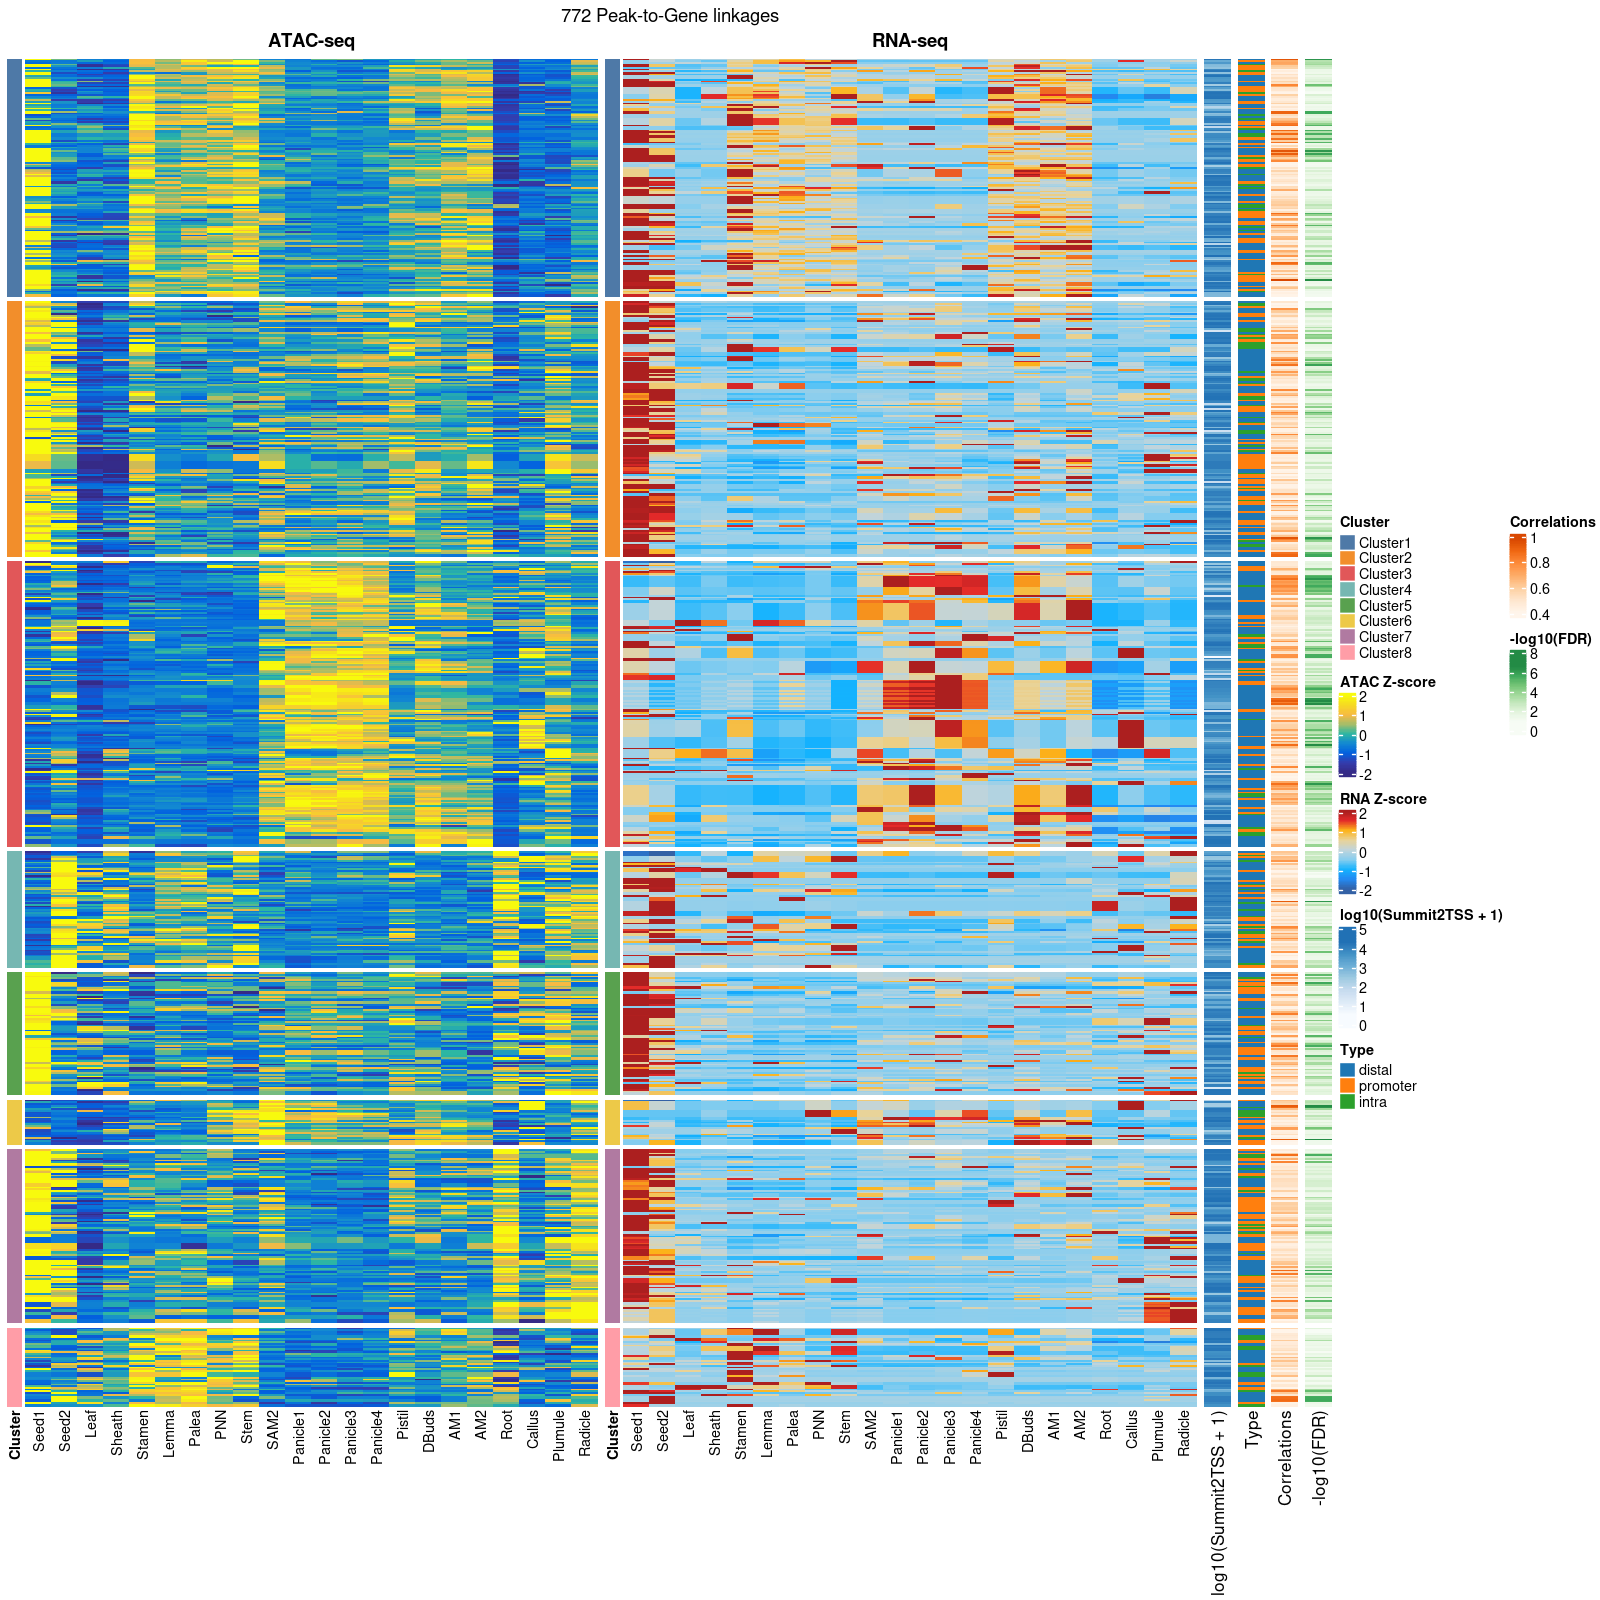

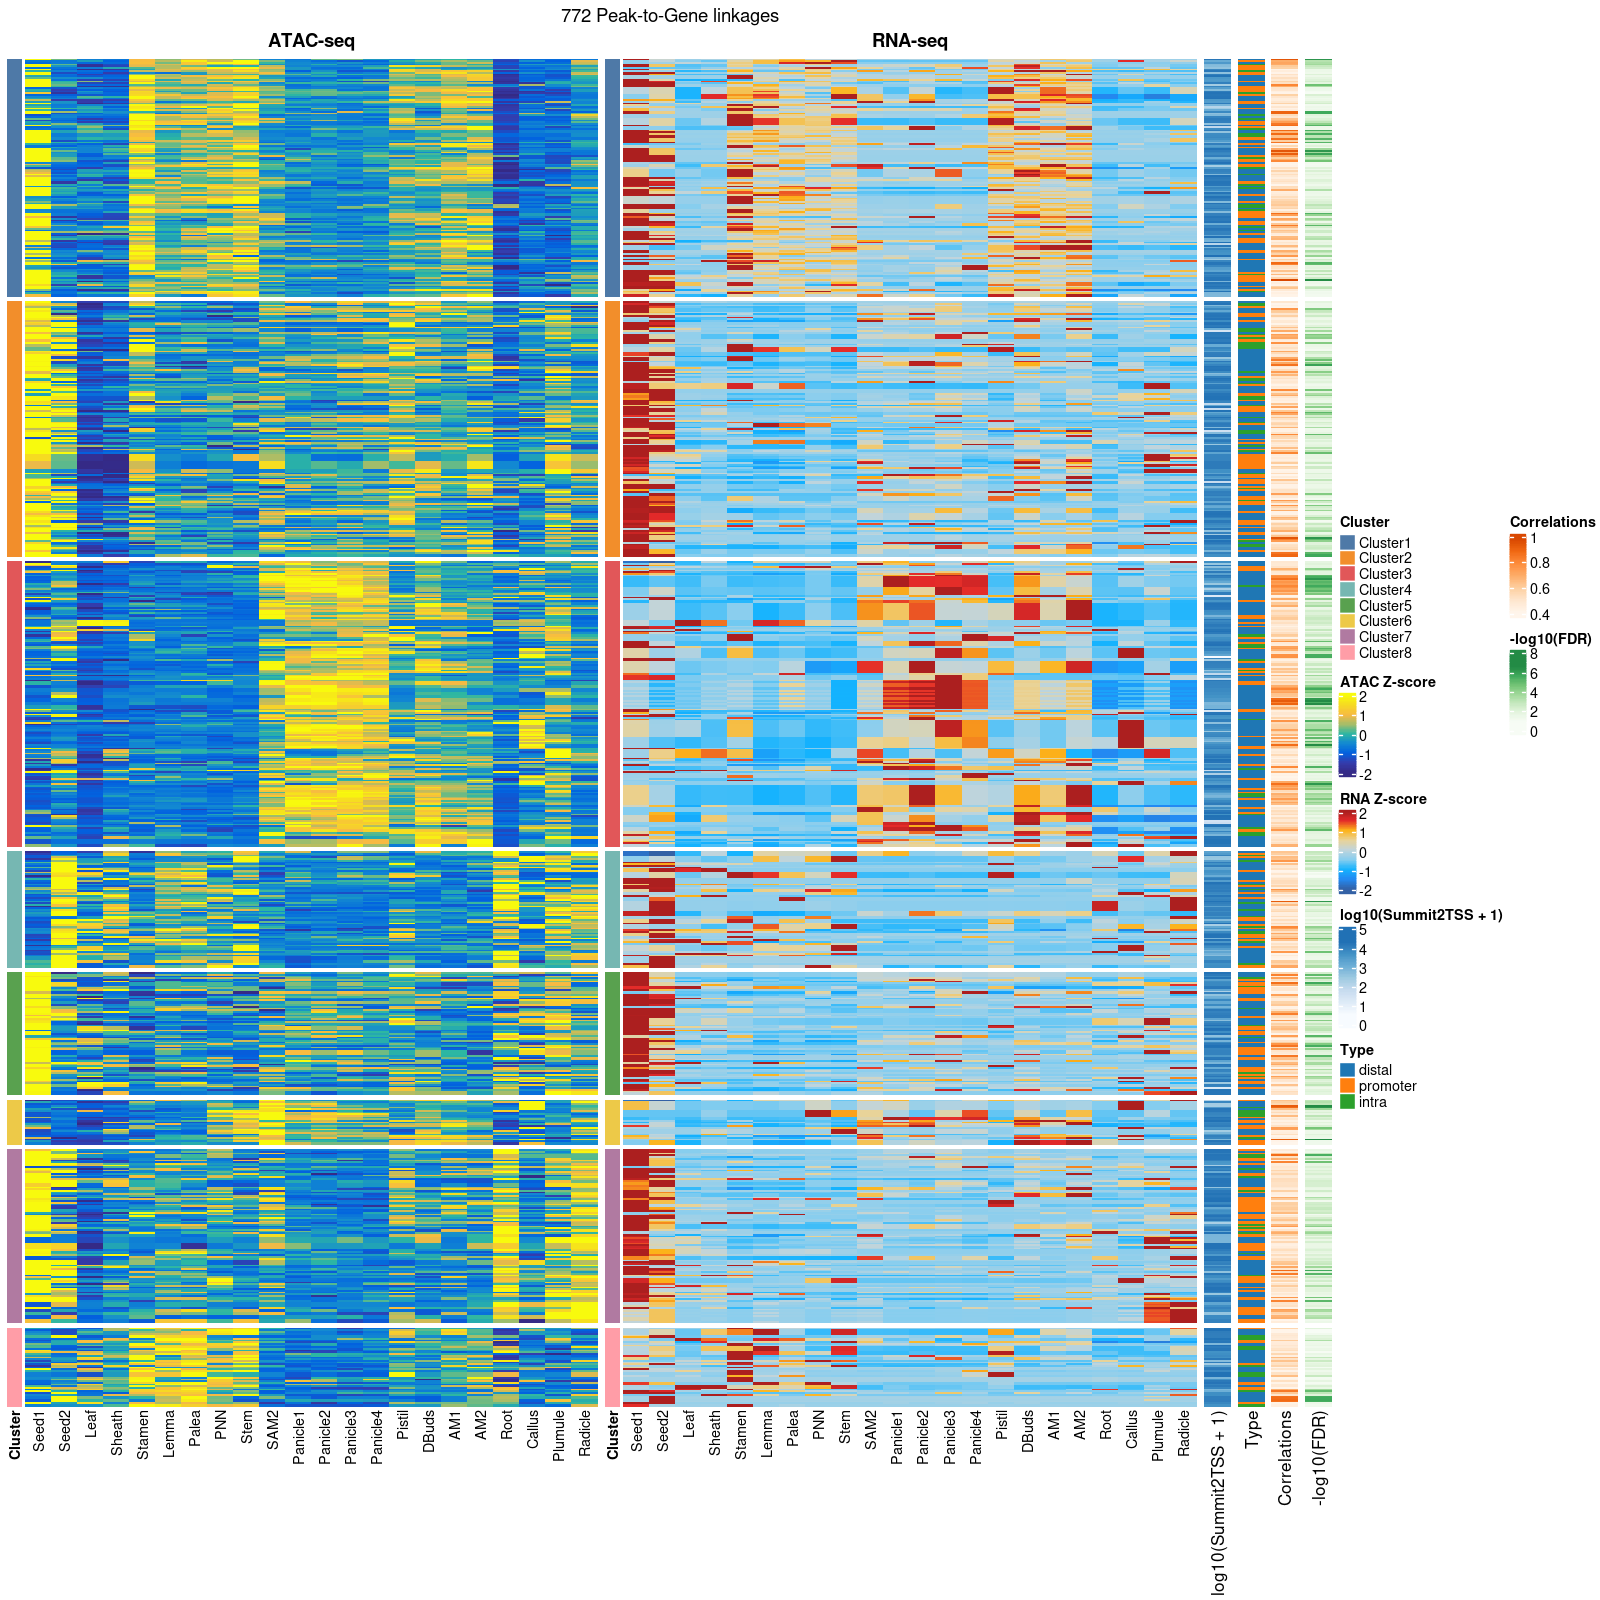

In [10]:
# plotP2GHeatmap <- function(p2g_res, cor_cutoff, atac_matrix, rna_matrix, cluster_N =4, raster = F,
#                            palATAC = NA, palRNA= NA, save_path=NA, fig_width=12,fig_height=12){
#   checkGeAnno()
library(paletteer)
cluster_N = 8
raster = F
library(dplyr)
blueYellow <- c("1"="#352A86","2"="#343DAE","3"="#0262E0","4"="#1389D2","5"="#2DB7A3","6"="#A5BE6A","7"="#F8BA43","8"="#F6DA23","9"="#F8FA0D")
solarExtra <- c("5"='#3361A5', "7"='#248AF3', "1"='#14B3FF', "8"='#88CEEF', "9"='#C1D5DC', "4"='#EAD397', "3"='#FDB31A',"2"= '#E42A2A', "6"='#A31D1D')
p2g <- readRDS("../Peak2Gene_All_Links.rds")
p2g <- p2g[p2g$correlations >= 0.4, ]
#logfile("This step may take a while, please wait...")
rna <- read.table("../microRNA_tpm.csv", header = T, row.names = 1)
p2g$idx_atac <- sprintf("ATAC_%s",1:nrow(p2g))
p2g$idx_rna <- sprintf("RNA_%s",1:nrow(p2g))
p2g_atac <- p2g[,c("Peak","idx_atac")]
rownames(p2g_atac) <- p2g_atac$idx_atac
atac <- read.table("../NIP_ATAC_all_tissues_norm_quant_final.tsv", row.names = 1, header = T)
atac_mat <- merge(p2g_atac, atac, by.x="Peak",by.y=0,all=F)
rownames(atac_mat) <- atac_mat$idx_atac
atac_mat <- atac_mat[,-c(1,2)]
atac_scale <- rowZscores(as.matrix(atac_mat),limit=T)

df1 <- rowZscores(as.matrix(atac_scale), limit = TRUE) %>% as.data.frame()
set.seed(2023)
row_dend <- hclust(dist(df1))
#mat <- df1[row_dend$order, ]
group <- data.frame(C=cutree(row_dend, k = as.integer(cluster_N)))
group$Cluster <- paste0("Cluster",group$C)
group <- group[order(group$Cluster),]
group$Cluster <- factor(group$Cluster, levels = sort(unique(group$Cluster)))
col_order <- c('Seed1','Seed2','Leaf','Sheath','Stamen','Lemma','Palea','PNN','Stem',
               'SAM2','Panicle1','Panicle2','Panicle3','Panicle4','Pistil','DBuds','AM1','AM2','Root','Callus','Plumule','Radicle')
mat <- df1[rownames(group),col_order]
group <- subset(group,select=-(C))
annotation <- mat[match(rownames(group),rownames(as.data.frame(mat))),]
mycol <- c(paletteer::paletteer_d("ggthemes::Tableau_10"), paletteer::paletteer_d("ggthemes::Tableau_20"))
gcols <- setNames(as.character(mycol[1:cluster_N]),unique(group$Cluster))
gcol <- list(Cluster=gcols)

N <- cluster_N - 1

p3 <- ComplexHeatmap::pheatmap(as.matrix(annotation), show_rownames=F,cluster_row=F,cluster_col=F,border_color=NA,use_raster=raster,
                               annotation_colors =gcol, color = colorRampPalette(blueYellow)(256),
                               annotation_row = group, gaps_row = cumsum(as.numeric(table(group$Cluster)))[1:N],
                               main="ATAC-seq",name="ATAC Z-score")
# Set the RNA matrix gene order
rownames(p2g) <- p2g$idx_atac
p2gnew <- p2g[rownames(group),]
p2g_rna <- p2gnew[,c("Gene","idx_rna")]
rna_order <- merge(p2g_rna, rna, by.x="Gene",by.y=0,all.x =T)
rownames(rna_order) <- rna_order$idx_rna
rna_order <- rna_order[p2gnew$idx_rna,-c(1,2)]
rna_order <- rna_order[,colnames(annotation)]
rna_scale <- rowZscores(as.matrix(rna_order),limit=T) %>% as.data.frame()

p4 <- ComplexHeatmap::pheatmap(as.matrix(rna_scale), show_rownames=F,cluster_row=F,cluster_col=F,border_color=NA,use_raster=raster,
                               annotation_colors =gcol, color = colorRampPalette(solarExtra)(256),
                               annotation_row = group, gaps_row = cumsum(as.numeric(table(group$Cluster)))[1:N],
                               main="RNA-seq", name="RNA Z-score")

pcor <- ComplexHeatmap::Heatmap(p2gnew$correlations, cluster_rows=F, name = "Correlations", col = paletteer::paletteer_d("RColorBrewer::Oranges")[1:7])
ppvalue <- ComplexHeatmap::Heatmap(-log10(p2gnew$FDR), cluster_rows=F, name = "-log10(FDR)", col = paletteer::paletteer_d("RColorBrewer::Greens")[1:7])
gene_type_col = setNames(as.character(paletteer_d("ggthemes::Classic_10")[1:length(unique(p2gnew$Type))]),unique(p2gnew$Type))
ptype <- ComplexHeatmap::Heatmap(p2gnew$Type, cluster_rows=F, name = "Type", col = gene_type_col)
pdis <- ComplexHeatmap::Heatmap(log10(abs(p2gnew$Summit2TSS)+1), cluster_rows=F, name = "log10(Summit2TSS + 1)", col = paletteer::paletteer_d("grDevices::blues9")[1:7])
options(repr.plot.width = 16, repr.plot.height = 16, repr.plot.res = 100)
pp <- ComplexHeatmap::draw(p3 + p4 + pdis + ptype + pcor + ppvalue, column_title = sprintf("%s Peak-to-Gene linkages",dim(p2g)[1]))
pp

Warning message:
“Removed 1 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


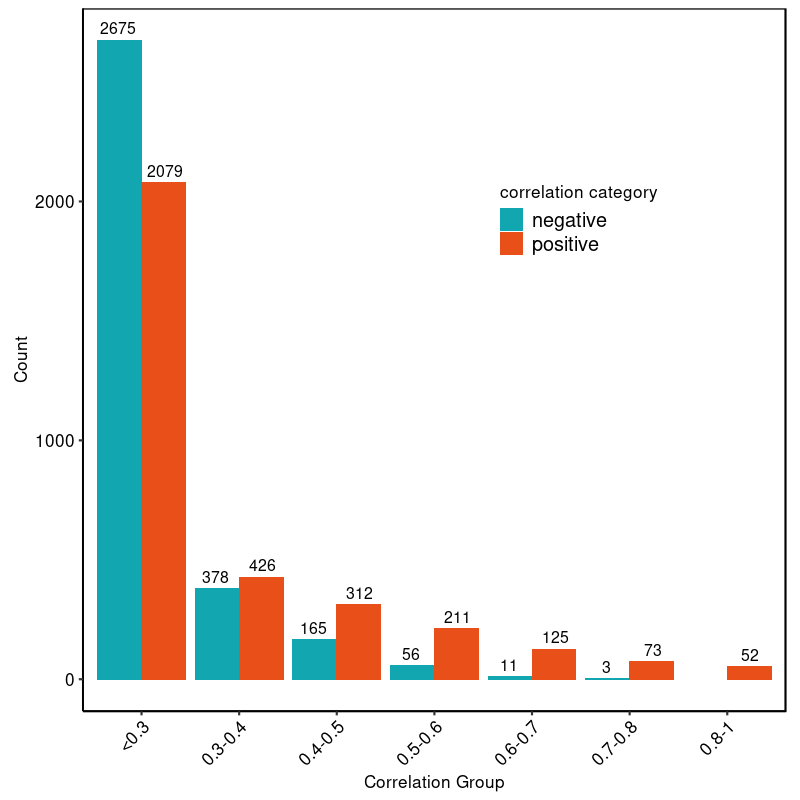

In [2]:
peak2miRNA_result <- readRDS('~/mirnome_data/peak2miRNA_links_category.RDS')
df <- as.data.frame(table(peak2miRNA_result$category,peak2miRNA_result$cor))
df$Freq1 <- ifelse(df$Freq==0,NA,df$Freq)

options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100)

p1 <- ggplot(df, aes(x = Var2, y = Freq1, fill = Var1)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_text(aes(label = ifelse(!is.na(Freq1), Freq1, "")), vjust = -0.5, position = position_dodge(width = 0.95)) +  # 添加数值标签，忽略缺失值
  labs(x = "Correlation Group", y = "Count", fill = NULL) +
  scale_fill_manual(values = c("negative" = "#11A6B0", "positive" = "#E94F18"),name="correlation category") +
  theme_pubr() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(panel.border = element_rect(colour = "black", fill = NA))
p1 <- p1+theme(legend.position = c(0.7, 0.7),legend.text = element_text(size = 14),aspect.ratio = 1)
p1

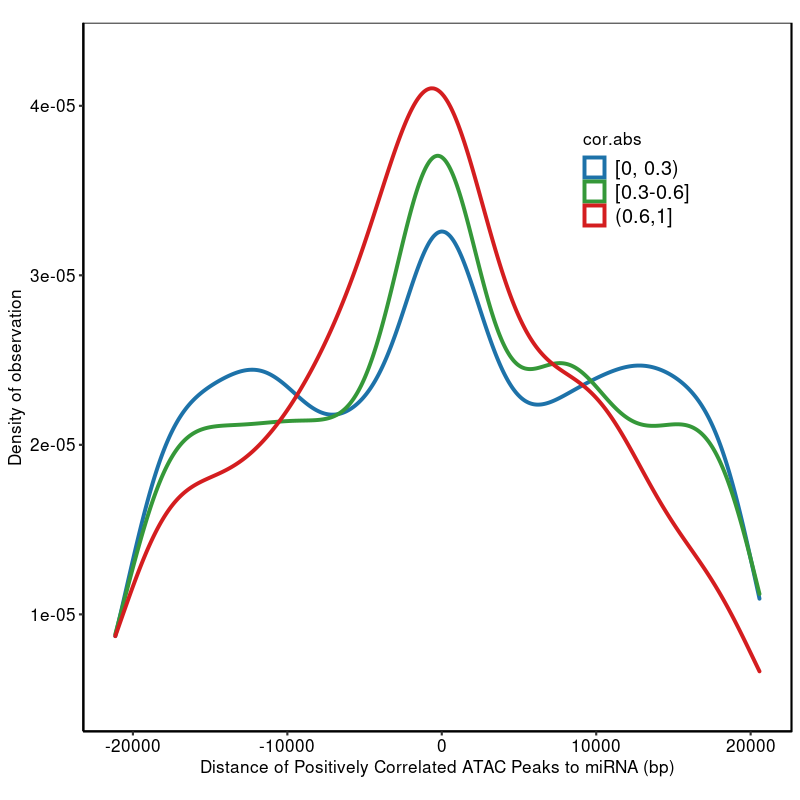

In [3]:
color_palette <- c("#1D72A9","#359839","#D41D1F")
peak2miRNA_result$cor_version2 <- ifelse(abs(peak2miRNA_result$correlations) < 0.3, "[0, 0.3)",
                                        ifelse(abs(peak2miRNA_result$correlations) < 0.6,  "[0.3-0.6]", "(0.6,1]"))
peak2miRNA_result$cor_version2 <- factor(peak2miRNA_result$cor_version2,levels = c("[0, 0.3)","[0.3-0.6]","(0.6,1]"))
peak2miRNA_result_positve <- peak2miRNA_result[peak2miRNA_result$category=='positive',]
p2 <- ggplot(data = peak2miRNA_result_positve, aes(x = Summit2TSS, color = factor(cor_version2))) +
  geom_density(adjust = 1, alpha = 0.2, size = 1) +  # 调整透明度以添加阴影
  scale_color_manual(values = color_palette,name="cor.abs") +
  labs(color = "Your Legend Title", fill = "Your Legend Title") +  # 修改图例标题
  theme_pubr() + 
  theme(panel.border = element_rect(colour = "black", fill = NA)) +
  ylab("Density of observation") +
  xlab("Distance of Positively Correlated ATAC Peaks to miRNA (bp)")+coord_cartesian(ylim = c(5e-6, 4.3e-5))

p2 <- p2 + theme(legend.position = c(0.78, 0.78),legend.text = element_text(size = 14))+ theme(aspect.ratio=1)
p2


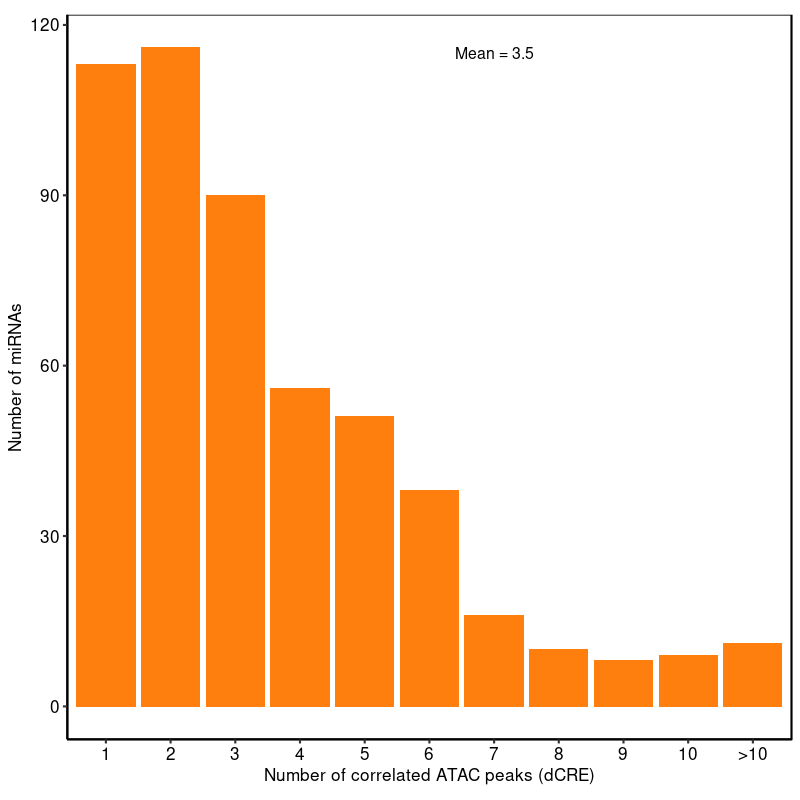

In [4]:
result_distal <- peak2miRNA_result[abs(peak2miRNA_result$correlations)>0.3,]
freq_miRNA_withCRE <- as.data.frame(table(result_distal$Gene))
freq_miRNA_withCRE$category <- freq_miRNA_withCRE$Freq
freq_miRNA_withCRE$category <- ifelse(freq_miRNA_withCRE$Freq>10,">10",freq_miRNA_withCRE$Freq)
df <- as.data.frame(table(freq_miRNA_withCRE$category))
custom_order <- c("1", "2", "3", "4", "5", "6", "7", "8", "9","10", ">10")
df$Var1 <- factor(df$Var1, levels = custom_order)
p3 <- ggplot(df, aes(x = Var1, y = Freq)) +
  geom_bar(stat = "identity", fill = "#FF7F0E") +
  xlab("Categories") +
  ylab("Frequency") +
  theme_pubr() +
  theme(panel.border = element_rect(colour = "black", fill = NA))+ 
  annotate("text", x = "7", y = 115, label = paste("Mean = ", round(mean(freq_miRNA_withCRE$Freq[freq_miRNA_withCRE$Freq != 0]), 2), sep = '')) +
  xlab("Number of correlated ATAC peaks (dCRE)")+ylab("Number of miRNAs")+theme(aspect.ratio=1)
    
p3

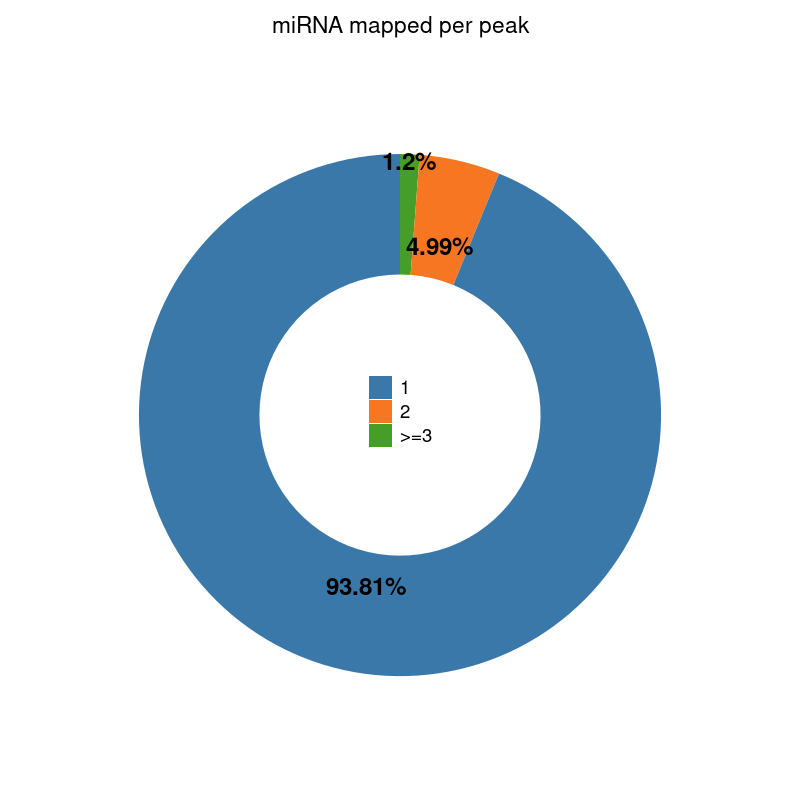

In [5]:
freq_CRE <- as.data.frame(table(result_distal$Peak))
freq_CRE$category <- ifelse(freq_CRE$Freq > 2, ">=3", as.character(freq_CRE$Freq))
df_CRE <- as.data.frame(table(freq_CRE$category))
# 自定义排序顺序
custom_order1 <- c("1", "2", ">=3")
df_CRE$Var1 <- factor(df_CRE$Var1, levels = custom_order1)
# df_CRE <- df_CRE %>% arrange(Var1)
df_CRE <- df_CRE %>% arrange(desc(Var1))
df_CRE['percent']=round(df_CRE['Freq']/colSums(df_CRE['Freq'])*100,2)
for(i in 1:dim(df_CRE)[1]){
  df_CRE$lab[i]=sum(df_CRE$percent[1:i])
}#计算val的累计和，用于求标签的y轴的中心位置
df_CRE$lab2[1]=df_CRE$percent[1]*1/2
for(i in 2:dim(df_CRE)[1]){
    df_CRE$lab2[i]=df_CRE$lab[i-1]+df_CRE$percent[i]*1/2
}
df_CRE$Var1 <- factor(df_CRE$Var1,levels = c("1","2",">=3"))

p4 <- ggplot() +
  geom_bar(data=df_CRE, aes(x=2, y=percent, fill=Var1), stat="identity", position="stack") +
  geom_text(data=df_CRE, aes(x=ifelse(Var1 == ">=3", 2.4, 1.8), y=lab2, label=paste0(percent, '%')), fontface="bold", size=6) +
  scale_x_continuous(limits=c(0.5, 2.8), expand=c(0, 0)) +
  scale_fill_manual(values=c("#3A78AA","#F77622","#459E27"), name=" ") +
  coord_polar(theta="y", start=0) +
  theme_void() +
  theme(legend.position=c(0.5, 0.52),legend.text = element_text(size = 13),
       plot.title = element_text(hjust = 0.5, vjust = -0.5, size = 16))+ ggtitle("miRNA mapped per peak")
p4

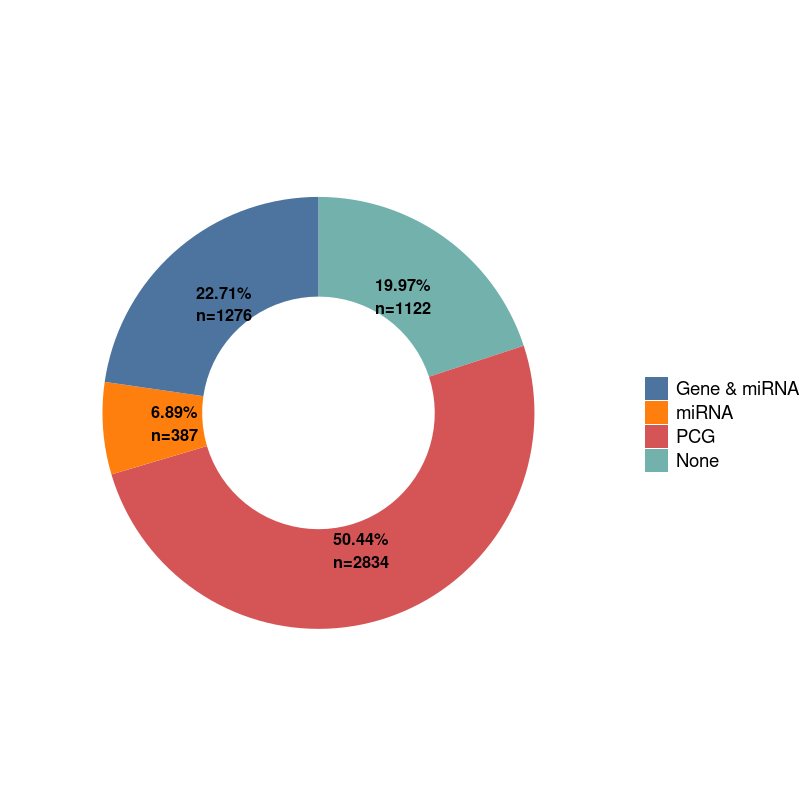

In [6]:
df <- readRDS("~/mirnome_data/Plot/regulation_type.RDS")

p5 <- ggplot() +
  geom_bar(data=df, aes(x=2, y=percent, fill=Var1), stat="identity", position="stack") +
  geom_text(data=df, aes(x=ifelse(Var1 == "miRNA", 1.8, 1.8), y=lab2, label=paste0(percent, '%',"\n","n=",Freq)), fontface="bold", size=4) +
  scale_x_continuous(limits=c(0.5, 2.8), expand=c(0, 0)) +
  scale_fill_manual(values=c("#4C749F","#FF7F0E","#D55557","#72B1AC"), name="") +
  coord_polar(theta="y", start=0) +
  theme_void() +
  theme(legend.position="right",legend.text = element_text(size = 13))+ggtitle(" ")
p5

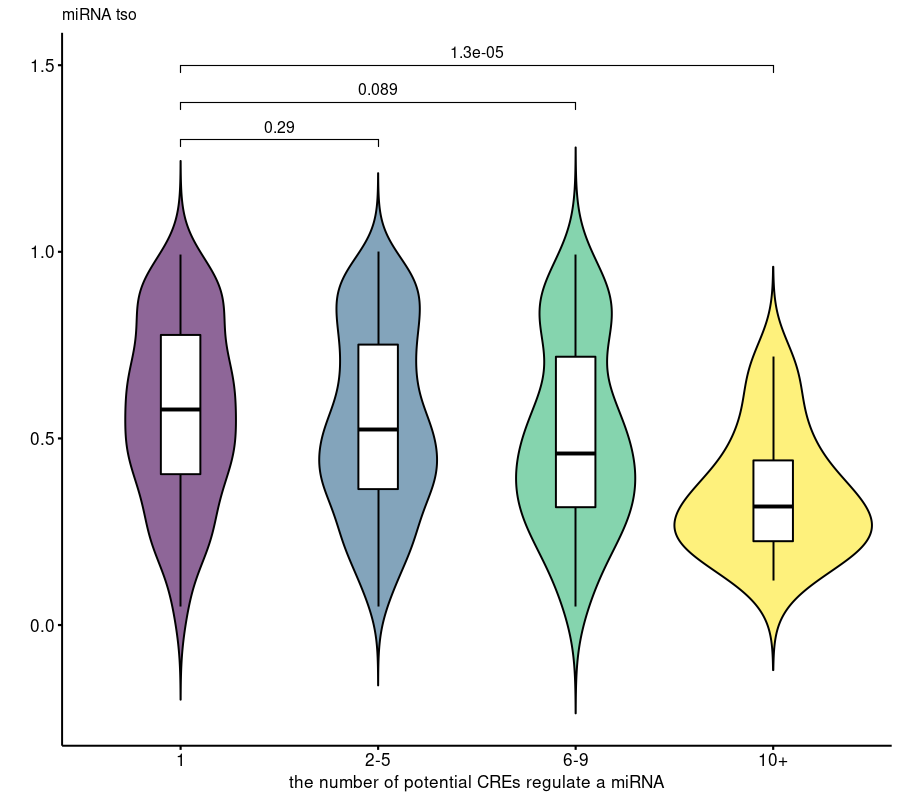

In [7]:
TSI_miRNA_withCRE <- readRDS("~/mirnome_data/Plot/tso_miRNA_peak_number.RDS")

options(repr.plot.height=8,repr.plot.width=9)
p6 <- ggviolin(TSI_miRNA_withCRE,"CATE","TSI",fill="CATE",add = "boxplot", add.params = list(fill = "white"),palette = c("#8E6698", "#83A4BB", "#85D4AE","#FEF17C"))+ theme(
      legend.position="none",
      plot.title = element_text(size=11)
    ) +
    ggtitle(paste0("miRNA tso")) +ylab("")+
    xlab("the number of potential CREs regulate a miRNA")+ geom_signif(comparisons = list(c("1","2-5"),c("1","6-9"),c("1","10+")),#设置需要比较的组
              test = t.test, ##计算方法
              y_position = c(1.3,1.4,1.5),#图中横线位置设置
              tip_length = c(c(0.02,0.02),c(0.02,0.02),c(0.02,0.02)),#横线下方的竖线设置
              size=0.3,color="black")
p6

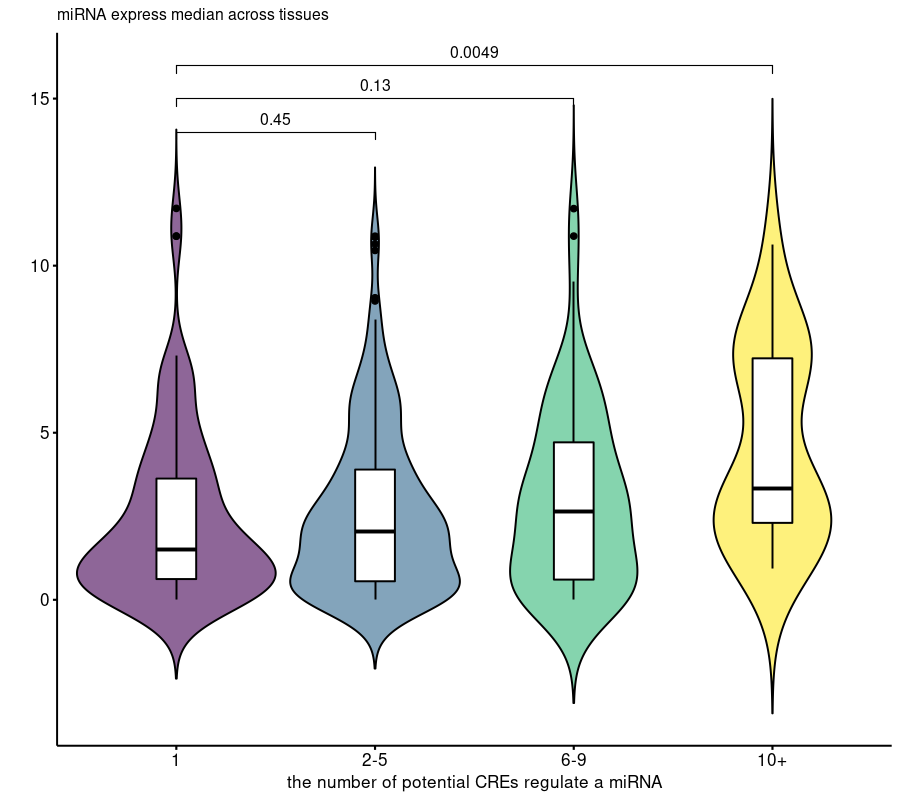

In [8]:
options(repr.plot.height=8,repr.plot.width=9)
medianexpress_miRNA_withCRE <- readRDS("~/mirnome_data/Plot/median_miRNA_express_peak_number.RDS")
medianexpress_miRNA_withCRE$log_express <- log(medianexpress_miRNA_withCRE$miRNA_express_median + 1)
p7 <- ggviolin(medianexpress_miRNA_withCRE,"CATE","log_express",fill="CATE",add = "boxplot", add.params = list(fill = "white"),palette = c("#8E6698", "#83A4BB", "#85D4AE","#FEF17C"))+ theme(
      legend.position="none",
      plot.title = element_text(size=11)
    ) +
    ggtitle(paste0("miRNA express median across tissues")) +ylab("")+
    xlab("the number of potential CREs regulate a miRNA")+ geom_signif(comparisons = list(c("1","2-5"),c("1","6-9"),c("1","10+")),#设置需要比较的组
              test = t.test, ##计算方法
              y_position = c(14,15,16),#图中横线位置设置
              tip_length = c(c(0.02,0.02),c(0.02,0.02),c(0.02,0.02)),#横线下方的竖线设置
              size=0.3,color="black")
p7

In [9]:
df <- readRDS("~/mirnome_data/Plot/miRNA_tso_express_median_miRNA_regulation_type.RDS")

In [10]:
options(repr.plot.height=8,repr.plot.width=2)

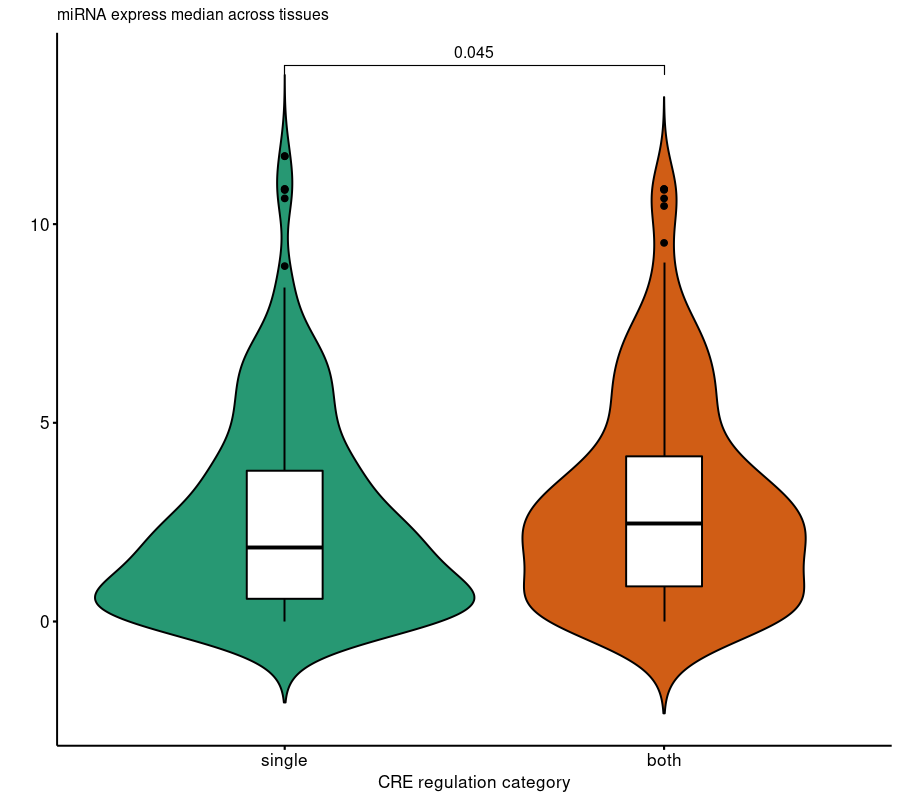

In [11]:
options(repr.plot.height=8,repr.plot.width=9)
p8 <- ggviolin(df,"Gene_category2","log_express",fill="Gene_category2",add = "boxplot", add.params = list(fill = "white"),palette = c("#279873", "#D05D15"))+ theme(
      legend.position="none",
      plot.title = element_text(size=11)
    ) +
    ggtitle(paste0("miRNA express median across tissues")) +ylab("")+
    xlab("CRE regulation category")+ geom_signif(comparisons = list(c("single","both")),#设置需要比较的组
              test = t.test, ##计算方法
              y_position = c(14,15,16),#图中横线位置设置
              tip_length = c(c(0.02,0.02),c(0.02,0.02),c(0.02,0.02)),#横线下方的竖线设置
              size=0.3,color="black")
p8

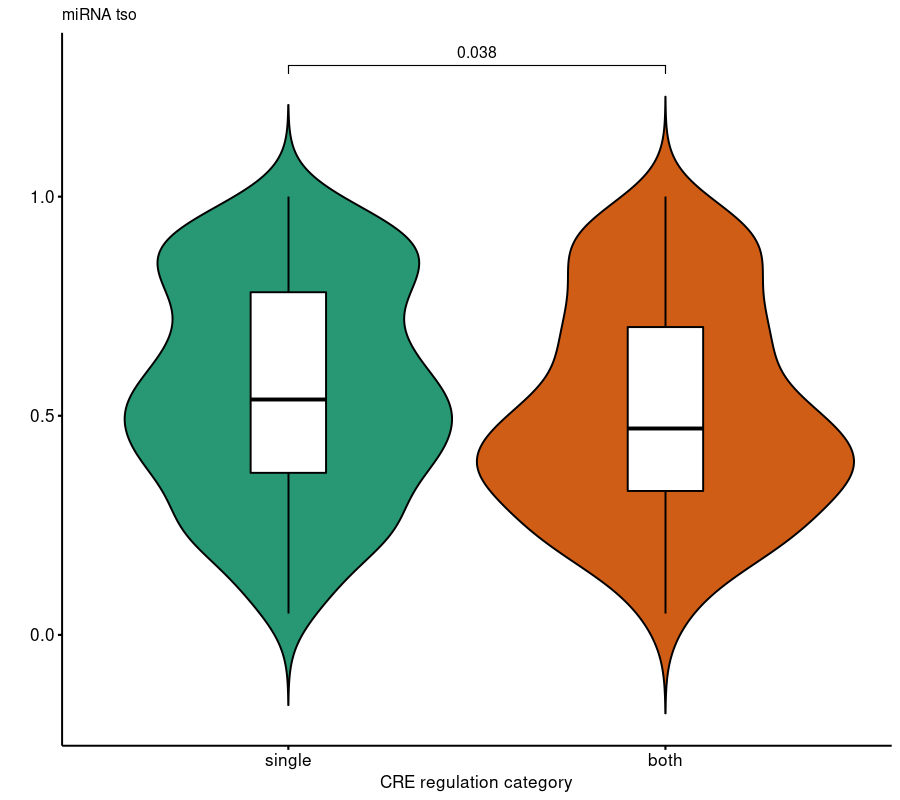

In [12]:
options(repr.plot.height=8,repr.plot.width=9)
p9 <- ggviolin(df,"Gene_category2","TSI",fill="Gene_category2",add = "boxplot", add.params = list(fill = "white"),palette = c("#279873", "#D05D15"))+ theme(
      legend.position="none",
      plot.title = element_text(size=11)
    ) +
    ggtitle(paste0("miRNA tso")) +ylab("")+
    xlab("CRE regulation category")+ geom_signif(comparisons = list(c("single","both")),#设置需要比较的组
              test = t.test, ##计算方法
              y_position = c(1.3,1.4,1.5),#图中横线位置设置
              tip_length = c(c(0.02,0.02),c(0.02,0.02),c(0.02,0.02)),#横线下方的竖线设置
              size=0.3,color="black")
p9